# Features comparison

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import mlflow
import mlflow.sklearn
import scipy
from tqdm.notebook import trange, tqdm

from DataHelper import *

# increase plot size
plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

In [2]:
DATA_PATH = './data'
QUOTATION = 'AAPL'
FILE_SUFFIX = '.txt'

In [3]:
predict_n = 1
price_column = 'Close'
df, feature_names = features_pipeline(f"{DATA_PATH}/{QUOTATION}{FILE_SUFFIX}", predict_n=predict_n,
    price_column=price_column, normalize_features=True)

df.head()

,Date,Open,High,Low,Close,Volume,Adjusted,Difference,PercentageDiff,Tendency,MA(10),MA(20) - MA(10),RSI(14),GAP,RSI_Diff,Volume_diff,Next
20,2007-01-31,3.030714,3.071429,3.012500,3.061786,856069200.0,2.641253,0.030354,0.308123,higher,-0.998898,0.059126,0.037469,-0.144495,0.127078,0.267772,lower
21,2007-02-01,3.079643,3.081071,3.026428,3.026428,664342000.0,2.610751,0.016131,0.007040,lower,-0.998887,0.059191,0.115874,-0.145814,0.042092,-0.447770,higher
22,2007-02-02,3.004286,3.044643,2.989286,3.026786,621530000.0,2.611059,0.025012,0.193105,higher,-0.998804,0.058848,0.077714,-0.149318,-0.102569,-0.084122,lower
23,2007-02-05,3.010714,3.043929,2.997857,2.997857,578852400.0,2.586104,0.028342,0.262292,lower,-0.998676,0.058768,0.185311,-0.153867,0.078321,-0.148500,higher
24,2007-02-06,3.016071,3.016786,2.959286,3.005357,864393600.0,2.592574,0.020225,0.092654,higher,-0.998758,0.060355,0.125932,-0.146497,-0.128903,-0.135701,higher


          Date      Open      High       Low     Close       Volume  Adjusted  \
20  2007-01-31  3.030714  3.071429  3.012500  3.061786  856069200.0  2.641253   
21  2007-02-01  3.079643  3.081071  3.026428  3.026428  664342000.0  2.610751   
22  2007-02-02  3.004286  3.044643  2.989286  3.026786  621530000.0  2.611059   
23  2007-02-05  3.010714  3.043929  2.997857  2.997857  578852400.0  2.586104   
24  2007-02-06  3.016071  3.016786  2.959286  3.005357  864393600.0  2.592574   

    Difference  PercentageDiff Tendency    MA(10)  MA(20) - MA(10)   RSI(14)  \
20    0.030354        0.308123   higher -0.998898         0.059126  0.037469   
21    0.016131        0.007040    lower -0.998887         0.059191  0.115874   
22    0.025012        0.193105   higher -0.998804         0.058848  0.077714   
23    0.028342        0.262292    lower -0.998676         0.058768  0.185311   
24    0.020225        0.092654   higher -0.998758         0.060355  0.125932   

         GAP  RSI_Diff  Volume_d

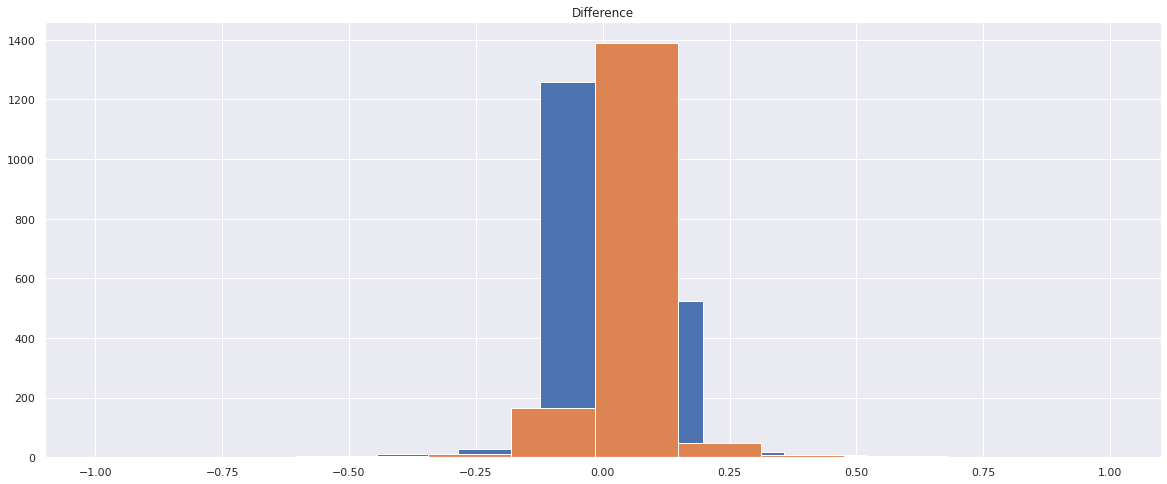

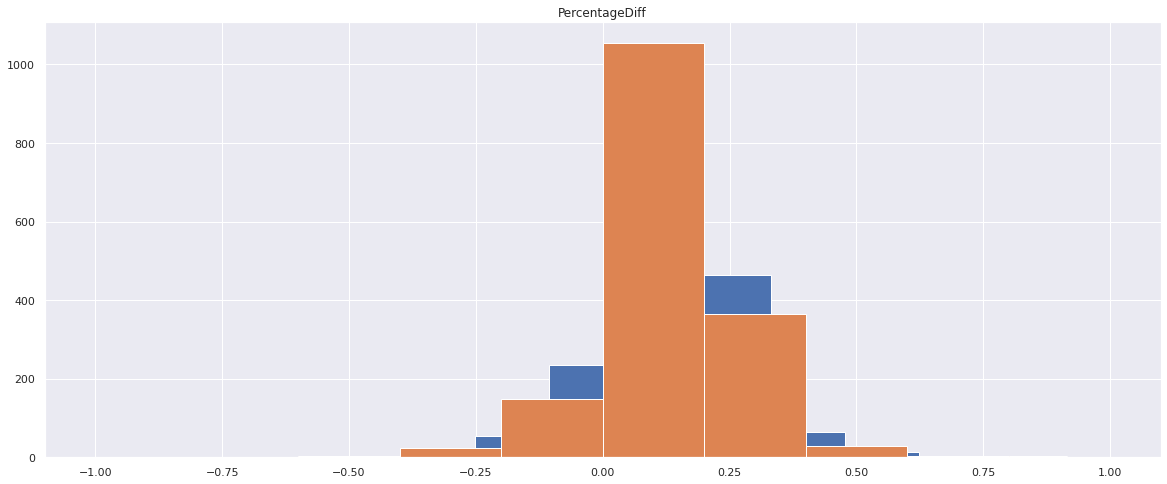

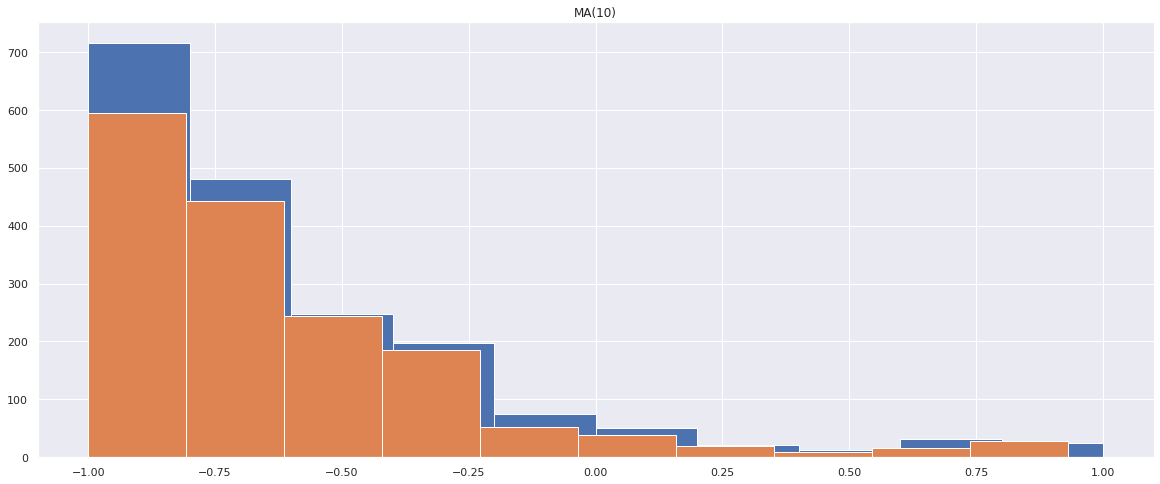

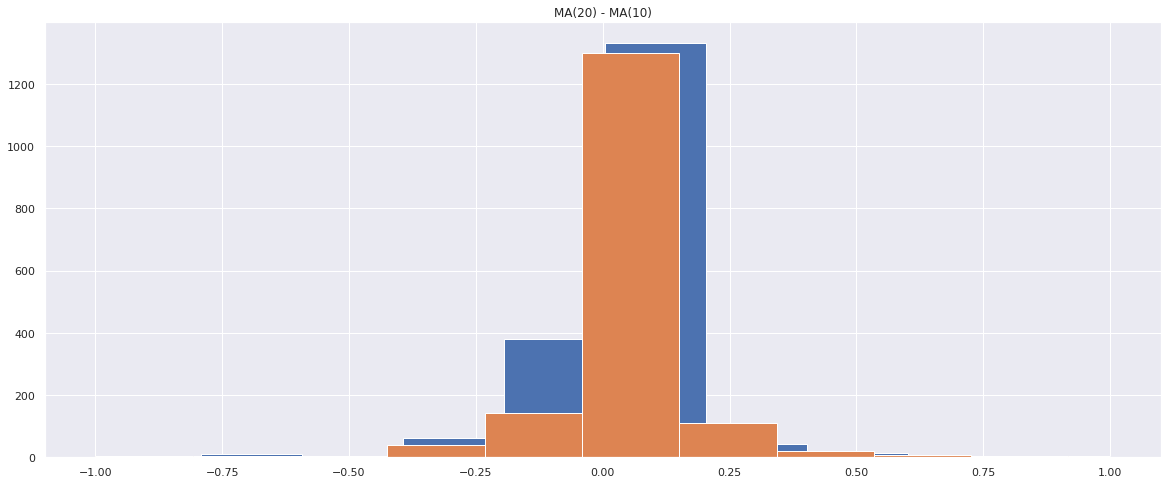

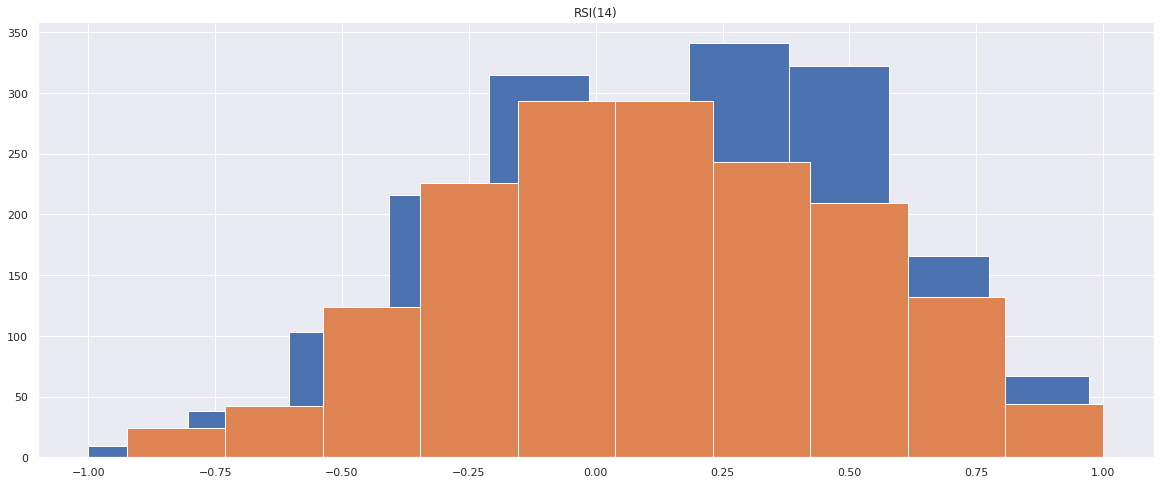

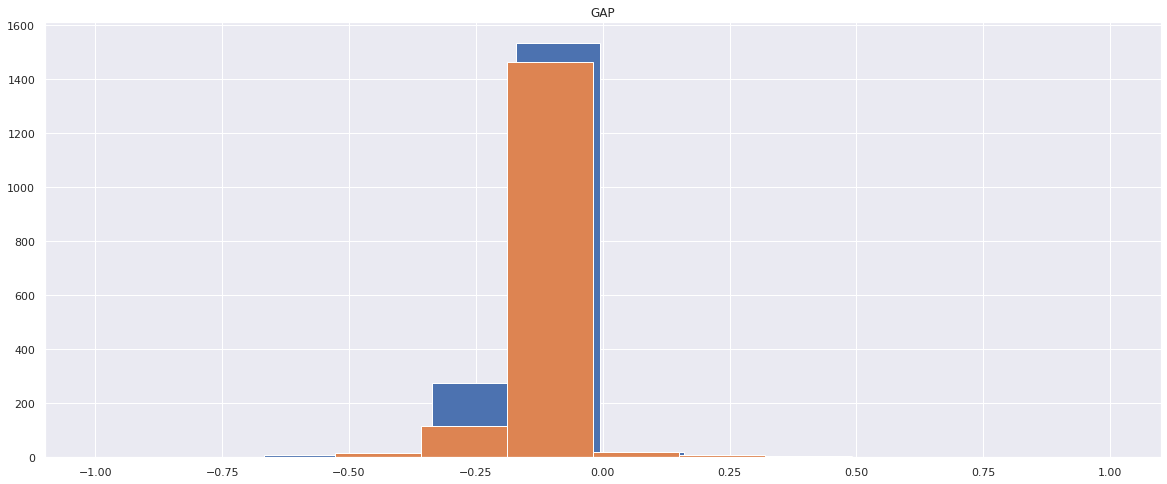

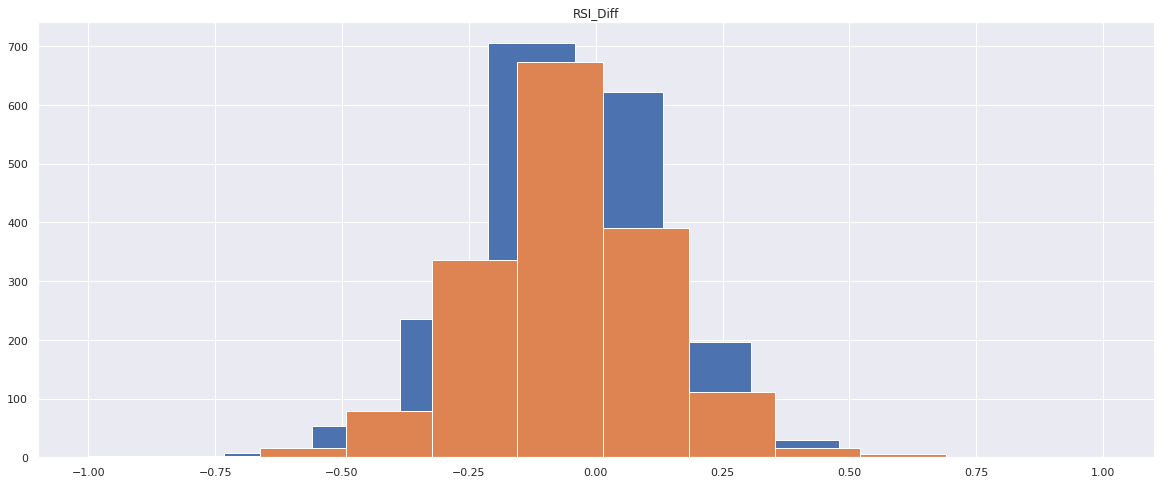

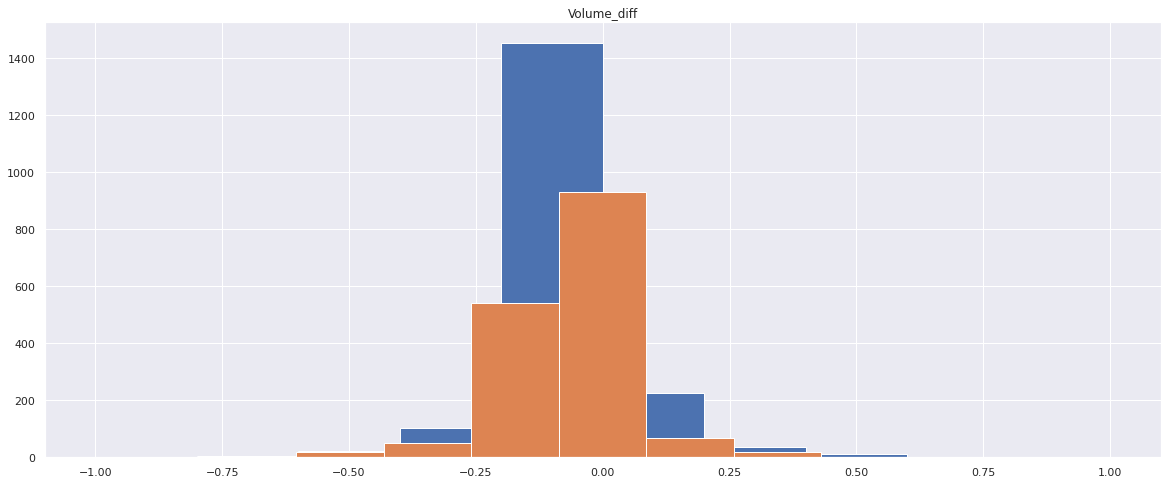

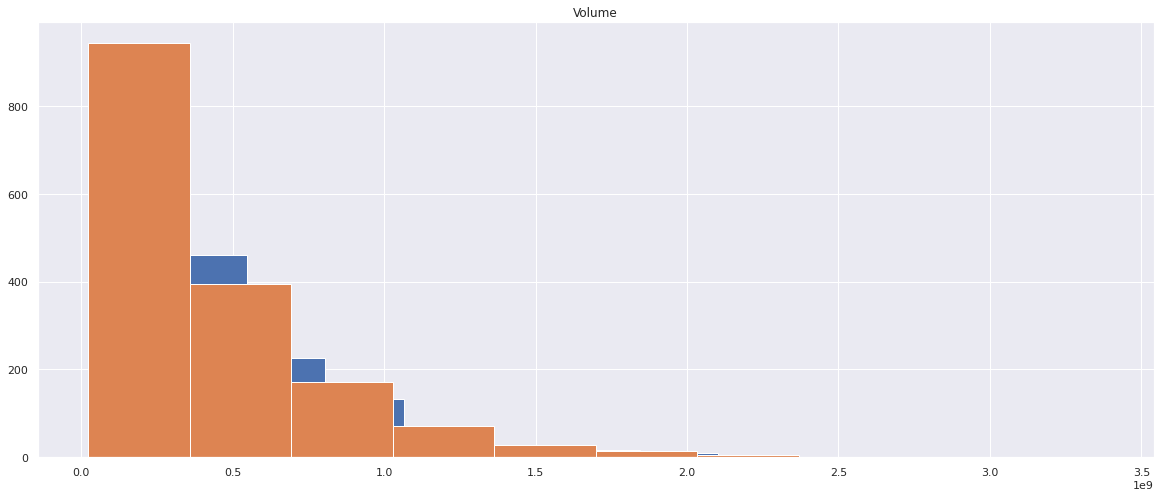

[('GAP', 0.03502052779451444), ('MA(20) - MA(10)', 0.11217575758072774), ('RSI(14)', 0.11725355817185583), ('MA(10)', 0.22705212468739547), ('Volume_diff', 0.3258971630467463), ('PercentageDiff', 0.4703737734485609), ('Difference', 0.5247035484875792), ('Volume', 0.561899293242988), ('RSI_Diff', 0.9008637439918843)]


In [4]:
from scipy import stats
EQUAL_VAR = False
PLOT_HISTS = True

classes = list(df['Next'].value_counts().to_dict().keys())
test_feature_names = feature_names + ['Volume']
test_feature_names = [feature for feature in test_feature_names if feature not in ['Next','Tendency']]

print(df.head())

features_p_vals = {}
for feature in test_feature_names:
    # get the filtered series with only the feature, filtered by the target class
    a = df[df['Next'] == classes[0]][feature]
    b = df[df['Next'] == classes[1]][feature]
    

    t_stat, p_computed = stats.ttest_ind(a, b, equal_var = EQUAL_VAR)
    features_p_vals[feature] = p_computed
    
    
    if PLOT_HISTS:
        a.hist()
        b.hist()
        plt.title(feature)
        plt.show()


    #print(f"[{feature}] : Computed p-value for: {p_computed}")

    

features_p_vals = sorted(features_p_vals.items(), key=lambda item:item[1])
print(features_p_vals)

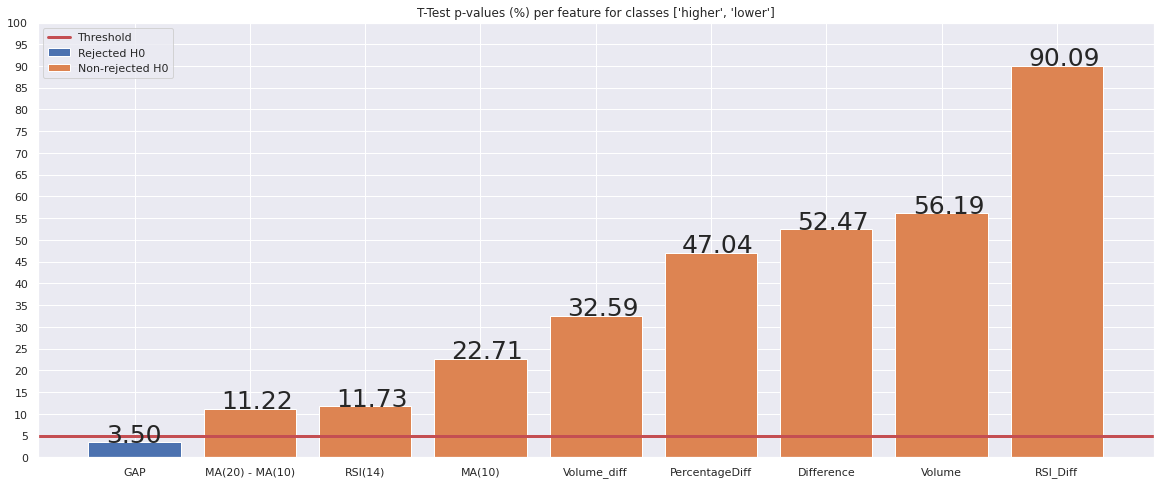

In [5]:
P_THRESH = 0.05

lowers = [t for t in features_p_vals if t[1] <= P_THRESH]
highers = [t for t in features_p_vals if t[1] >= P_THRESH]


plt.bar([t[0] for t in lowers], [t[1]*100 for t in lowers], label="Rejected H0") 
plt.bar([t[0] for t in highers], [t[1]*100 for t in highers], label="Non-rejected H0")


x_locs, _ = plt.xticks()
for i, value in enumerate([x[1]*100 for x in features_p_vals]):
    plt.text(x_locs[i] - 0.25, value + 0.01, f"{value:.2f}")
    
plt.axhline(y = P_THRESH * 100, color = 'r', linestyle = '-', linewidth=3.0, label="Threshold")
plt.yticks(np.arange(0, 101, step=5))
plt.title(f"T-Test p-values (%) per feature for classes {classes}")
plt.legend(loc='best')
plt.show()